In [1]:
import numpy as np
import pandas as pd
from bayestme import data, deconvolution, plotting
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import os

First, let's load the data

In [2]:
data_path = '../data/spatial_benchmarks'
count_mat = pd.read_csv(os.path.join(data_path, 'combined_spatial_count.txt'), sep='\t')
gene_names = count_mat.columns
count_mat = count_mat.values.astype(int)
coordinates = pd.read_csv(os.path.join(data_path, 'combined_Locations.txt'), sep='\t').values.astype(int)
n_spots, n_genes = count_mat.shape

and prepare the data for BayesTME

In [3]:
stdata = data.create_anndata_object(counts=count_mat, 
                                    coordinates=coordinates, 
                                    tissue_mask=np.ones(n_spots).astype(bool),
                                    gene_names=gene_names, 
                                    layout=data.Layout.SQUARE)
stdata = data.SpatialExpressionDataset(stdata)

/Users/hrzhang/anaconda3/lib/python3.8/site-packages/bayestme-0.1.0-py3.8.egg/bayestme/data.py:68: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = anndata.AnnData(counts, obsm={SPATIAL_ATTR: coordinates})


### Reference-free approach

We start with the default reference-free approach

In [4]:
np.random.seed(0)
rng = np.random.default_rng(1)
deconvolution_result = deconvolution.deconvolve(reads=stdata.reads,
                                                edges=stdata.edges,
                                                n_gene=n_genes,
                                                n_components=15,
                                                lam2=1e6,
                                                n_samples=200,
                                                n_burnin=500,
                                                n_thin=5,
                                                D=20,
                                                bkg=False,
                                                lda=False,
                                                rng=rng)

Deconvolution: 100%|████████████████████████| 1500/1500 [40:03<00:00,  1.60s/it]


we reorder the detected cell types for the benchmarks using the single cell reference

In [5]:
from scipy import stats as st
spatial_rna = pd.read_csv(os.join(data_path, 'Spatial_count.txt'), sep='\t',index_col=0)
spatial_meta = pd.read_csv(os.join(data_path, 'Spatial_annotate.txt'), sep='\t',index_col=0)
cell_types = np.unique(spatial_meta['celltype'])
n_cell_types = cell_types.shape[0]
sc_exp = np.zeros((n_cell_types, n_genes))
for i, ct in enumerate(cell_types):
    sc_exp[i] = spatial_rna[spatial_meta['celltype'] == ct].mean().values
top = np.argsort(np.std(np.log(1 + stdata.reads), axis=0))[::-1]
sc_exp_ref = sc_exp[:, top]
sc_exp_ref = sc_exp_ref/sc_exp_ref.sum(axis=1, keepdims=True)
celltype_order = deconvolution_result.align_celltype(sc_exp_ref, n=50)

and filter out the selected cell types for benchmarking following Li et al. (2022)

In [6]:
selected = np.ones(15).astype(bool)
filtered = [6, 8, 10]
selected[filtered] = 0

We first test the performence on the expression profile estimation

/var/folders/41/wxyyz25j4m324br78sjcqf5w0000gn/T/ipykernel_88075/1793921222.py:7: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(ground_truth_expression), np.log(bayestme_expression), c='C0', alpha=0.08)


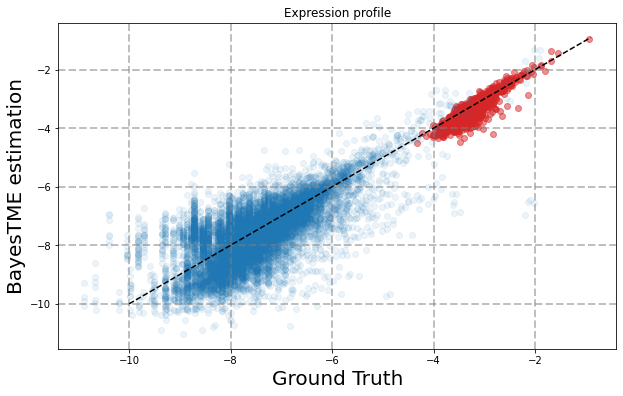

In [7]:
expression_post = deconvolution_result.expression_trace[-100:].mean(axis=0)
bayestme_expression = expression_post[celltype_order[selected]].reshape(-1)
ground_truth_expression = (sc_exp_ref[selected]).reshape(-1)

fig,ax = plt.subplots(figsize=(10, 6))
plt.scatter(np.log10(sc_exp_ref[3]), np.log10(expression_post[1]), c='C3', alpha=0.5)
plt.scatter(np.log(ground_truth_expression), np.log(bayestme_expression), c='C0', alpha=0.08)
ax.plot([-10, -0.9], [-10, -0.9], c='k', ls='--')
ax.grid(color='gray', linestyle='--', alpha=0.5, linewidth=2)
plt.xlabel('Ground Truth', fontsize=20)
plt.ylabel('BayesTME estimation', fontsize=20)
plt.title('Expression profile')
plt.show()

Then we take L4 excited neurons as an example to see the performence of cell type proportion estimation. The Pearson's r correlation is 0.92.

Quantitative benchmark on cell type proportion of all cell types will be conducted later on.

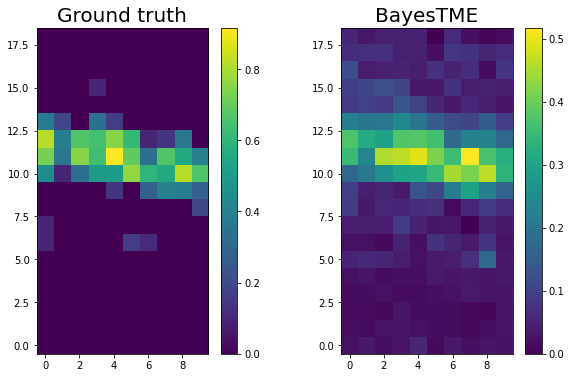

cell num proportion pearson's r: 0.9281929584918805


In [9]:
ground_truth_cell_num = pd.read_csv(
                                    os.path.join(data_path, 'combined_spot_clusters.txt'),
                                    sep='\t'
                                    ).values[:, 1:].astype(int)
celltype = 3
ncell_post_mean = deconvolution_result.cell_num_trace[:, :, 1:].mean(axis=0)
cell_prop = (ncell_post_mean/ncell_post_mean.sum(axis=1, keepdims=True))[:, celltype_order]
ground_truth_cell_prop = ground_truth_cell_num/ground_truth_cell_num.sum(axis=1, keepdims=True)
plot_gt = np.zeros((10, 19))
plot_bayestme = np.zeros_like(plot_gt)
for i in range(coordinates.shape[0]):
    plot_bayestme[coordinates[i, 0], coordinates[i, 1]] = cell_prop[i, celltype]
    plot_gt[coordinates[i, 0], coordinates[i, 1]] = ground_truth_cell_prop[i, celltype]

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
im = ax[0].imshow(plot_gt.T)
plt.colorbar(im, ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Ground truth', fontsize=20)
im = ax[1].imshow(plot_bayestme.T)
plt.colorbar(im, ax=ax[1])
ax[1].invert_yaxis()
ax[1].set_title('BayesTME', fontsize=20)
plt.show()
cell_prop_r = pearsonr(cell_prop[:, celltype], ground_truth_cell_prop[:, celltype])[0]
print('cell num proportion pearson\'s r: {}'.format(cell_prop_r))

### scRNA guided approach
If we want to use scRNA reference to guide the deconvolution, we simply need to pass the scRNA reference to the `expression_truth` parameter of BayesTME

In [11]:
np.random.seed(0)
rng = np.random.default_rng(1)
scref_deconvolution_result = deconvolution.deconvolve(reads=stdata.reads,
                                                edges=stdata.edges,
                                                n_gene=n_genes,
                                                n_components=15,
                                                lam2=1e6,
                                                n_samples=200,
                                                n_burnin=500,
                                                n_thin=5,
                                                expression_truth=sc_exp,
                                                n_max=60,
                                                D=20,
                                                bkg=False,
                                                lda=False,
                                                rng=rng)

Deconvolution: 100%|████████████████████████| 1500/1500 [13:37<00:00,  1.83it/s]


### Quantitative benchmark

Now, let's compare BayesTME's performance to the existing methods. Adpoted from Li et al. (2022), we test the accuracy of the cell type proportion of the deconvolution results. Following Li et al, we use the AS metric (based on Pearson's correlation coefficient, structural similarity, RMSE, and Jensen-Shannon divergence).

First, we need to load the ground truth and the dconvolution results of the existing methods.

In [12]:
from spatial_benchmark_metric import load_benchmark_results, compare_results, make_score

In [13]:
bayestme_cellnum = deconvolution_result.cell_num_trace[:, :, 1:]
bayestme_scref_cellnum = scref_deconvolution_result.cell_num_trace[:, :, 1:]

In [14]:
gd_results, benchmark_results = load_benchmark_results('../data/spatial_benchmarks')

Clean up the BayesTME deconvolution results, in order to align with the format of the benchmark results.

In [15]:
ncell_post_mean = bayestme_cellnum.mean(axis=0)
bayestme_result = pd.DataFrame((ncell_post_mean/ncell_post_mean.sum(axis=1, keepdims=True))[:, celltype_order])
bayestme_result.columns = ['Astro', 'Endo', 'Excitatory L2/3', 'Excitatory L4', 'Excitatory L5', 
                                 'Excitatory L6', 'HPC', 'Micro', 'Npy', 'Olig', 'Other', 
                                 'Inhibitory Pvalb', 'Smc', 'Inhibitory Sst', 'Inhibitory Vip']
bayestme_result = bayestme_result.drop(columns=['Other','Npy', 'HPC'])
bayestme_result = bayestme_result.loc[:, np.unique(gd_results.columns)]

ncell_scref_post_mean = bayestme_scref_cellnum.mean(axis=0)
bayestme_scref_result = pd.DataFrame(ncell_scref_post_mean/ncell_scref_post_mean.sum(axis=1, keepdims=True))
bayestme_scref_result.columns = ['Astro', 'Endo', 'Excitatory L2/3', 'Excitatory L4', 'Excitatory L5', 
                                 'Excitatory L6', 'HPC', 'Micro', 'Npy', 'Olig', 'Other', 
                                 'Inhibitory Pvalb', 'Smc', 'Inhibitory Sst', 'Inhibitory Vip']
bayestme_scref_result = bayestme_scref_result.drop(columns=['Other','Npy', 'HPC'])
bayestme_scref_result = bayestme_scref_result.loc[:, np.unique(gd_results.columns)]

Calculate the scores on Pearson's correlation coefficient, structural similarity, RMSE, and Jensen-Shannon divergence respectively

In [16]:
test_results = [bayestme_result, bayestme_scref_result] + benchmark_results
test_names = ['BayesTME', 'BayesTME*', 'RCTD', 'Cell2location', 'Tangram', 
              'Seurat', 'Stereoscope', 'SPOTlight', 'SpatialDWLS', 
              'DestVI', 'DSTG', 'STRIDE', 'SpaOTsc', 'NovoSparc']

In [17]:
starmap_clusters_pcc = compare_results(gd_results, test_results, columns = test_names, axis=1, metric='pcc')
starmap_clusters_ssim = compare_results(gd_results, test_results, columns = test_names, axis=1, metric='ssim')
starmap_clusters_rmse = compare_results(gd_results, test_results, columns = test_names, axis=1, metric='rmse')
starmap_clusters_jsd = compare_results(gd_results, test_results, columns = test_names, axis=1, metric='jsd')

/Users/hrzhang/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hrzhang/anaconda3/lib/python3.8/site-packages/scipy/spatial/distance.py:1295: RuntimeWarning: invalid value encountered in true_divide
  q = q / np.sum(q, axis=axis, keepdims=True)


The boxplot show the performence of each method on the four basic metrics with detial. BayesTME get the best average performence (indicated by teh red triangels) in all basic metrics (in PCC and SSIM, the better method gets score closer to 1, and in RMSE and JSD, the better method gets score closer to 0).

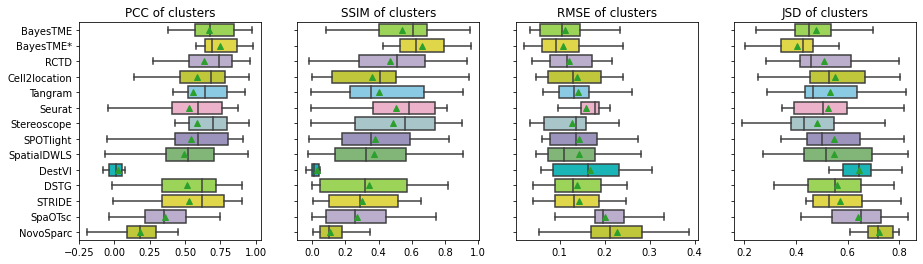

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
fig,axes = plt.subplots(ncols=4, nrows=1, figsize=(15,4))
colors = ["#9de846", '#F9EC31', "#BBA8D1","#D6DE23", "#7BD1F1", "#F5A8C7",  "#A2CBCF", "#988DC3", "#79c06e",'#00CED1']
sns.boxplot(data=starmap_clusters_pcc, order=test_names, palette=colors, 
            ax=axes[0], orient='h', showfliers = False, showmeans=True)
axes[0].set_title('PCC of clusters')
sns.boxplot(data=starmap_clusters_ssim, order=test_names, palette=colors, 
            ax=axes[1], orient='h', showfliers = False, showmeans=True)
axes[1].set_title('SSIM of clusters')
axes[1].set(yticklabels=[])
sns.boxplot(data=starmap_clusters_rmse, order=test_names, palette=colors, 
            ax=axes[2], orient='h', showfliers = False, showmeans=True)
axes[2].set_title('RMSE of clusters')
axes[2].set(yticklabels=[])
sns.boxplot(data=starmap_clusters_jsd, order=test_names, palette=colors, 
            ax=axes[3], orient='h', showfliers = False, showmeans=True)
axes[3].set_title('JSD of clusters')
axes[3].set(yticklabels=[])
plt.show()

The AS barchart gives a more direct comparison of the methods, BayesTME and sc-reference-guided BayesTME outperforms all the existing methods.

In [19]:
for test in test_names:
    Metric = pd.concat([starmap_clusters_pcc[test], starmap_clusters_ssim[test], 
                        starmap_clusters_rmse[test], starmap_clusters_jsd[test]], axis = 1)
    Metric.columns = ['PCC', 'SSIM', 'RMSE', 'JS']
    Metric.to_csv('STARmap_' + test + '_Metrics.txt', sep = '\t')

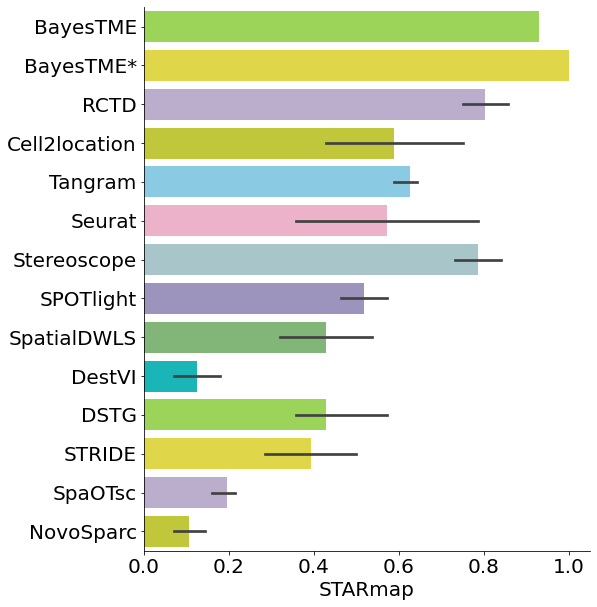

In [20]:
Data = 'STARmap'
dataset = make_score(Data, test_names)
palette = ["#9de846", '#F9EC31', "#BBA8D1", "#D6DE23", "#7BD1F1",
           "#F5A8C7", "#A2CBCF", "#988DC3", "#79c06e", '#00CED1']

dataset_mer = pd.concat([dataset.iloc[:,0], dataset.iloc[:,1], dataset.iloc[:,2], dataset.iloc[:,3]], axis = 0)
dataset_mer  = pd.DataFrame(dataset_mer, index =dataset_mer.index.values, columns=[Data])
plt.figure(figsize=(8, 10))
axes = sns.barplot(x = Data, y = dataset_mer.index.values, data = dataset_mer, order = test_names, palette = palette)
axes.set_xlabel(Data, fontsize = 20)
axes.set_ylabel('', fontsize = 10)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()